In [1]:
import tensorflow as tf
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Flatten, Dense, LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
s_weather_df = pd.read_csv('SWeather2018.csv', sep=';', decimal=',')
pd.options.display.max_rows = 10
display(s_weather_df)

,Datum,MedTemp,MaxTemp,MinTemp,Niederschlag,Monat,MedGlobalstrahlung,MedStarhlungBilanz
0,01.01.2014,6.2,9.8,2.4,0.00,1.0,44.9,-17.8
1,02.01.2014,7.0,10.0,4.8,1.60,1.0,24.3,-37.1
2,03.01.2014,7.8,10.8,4.3,0.30,1.0,22.4,-35.1
3,04.01.2014,7.7,9.7,5.6,1.33,1.0,11.9,-31.8
4,05.01.2014,5.8,8.6,1.4,0.72,1.0,29.1,-41.2
...,...,...,...,...,...,...,...,...
1885,01.03.2019,9.2,11.9,7.6,5.60,3.0,51.9,-1.5
1886,02.03.2019,9.2,12.3,7.1,0.00,3.0,54.0,16.4
1887,03.03.2019,11.1,13.6,7.7,0.00,3.0,59.6,11.6
1888,04.03.2019,9.9,14.3,4.8,4.40,3.0,72.0,-0.6


In [4]:
s = s_weather_df['MedTemp']

In [7]:
lastN = 3
until = 1
cols = [1, 2, 3, 4, 5, 6, 7]
#cols = [1]

x = []
for i in range(lastN, s.size):
    x_inputs = []
    for j in cols:
        for k in range(i - lastN, i):
            x_inputs.append(s_weather_df.iloc[k, j])
    x.append(x_inputs)

y = []
for i in range(lastN, s.size):
    # y.append([s_weather_df.iloc[i, 1]])
    y_inputs = []
    for j in cols:
        y_inputs.append(s_weather_df.iloc[i, j])
    y.append(y_inputs)

for i in range(len(x)):    
    print(i, x[i], y[i])

0 [6.2, 7.0, 7.8, 9.8, 10.0, 10.8, 2.4, 4.8, 4.3, 0.0, 1.6, 0.3, 1.0, 1.0, 1.0, 44.9, 24.3, 22.4, -17.8, -37.1, -35.1] [7.7, 9.7, 5.6, 1.33, 1.0, 11.9, -31.8]
1 [7.0, 7.8, 7.7, 10.0, 10.8, 9.7, 4.8, 4.3, 5.6, 1.6, 0.3, 1.33, 1.0, 1.0, 1.0, 24.3, 22.4, 11.9, -37.1, -35.1, -31.8] [5.8, 8.6, 1.4, 0.72, 1.0, 29.1, -41.2]
2 [7.8, 7.7, 5.8, 10.8, 9.7, 8.6, 4.3, 5.6, 1.4, 0.3, 1.33, 0.72, 1.0, 1.0, 1.0, 22.4, 11.9, 29.1, -35.1, -31.8, -41.2] [7.1, 12.2, 1.0, 0.0, 1.0, 33.8, -10.0]
3 [7.7, 5.8, 7.1, 9.7, 8.6, 12.2, 5.6, 1.4, 1.0, 1.33, 0.72, 0.0, 1.0, 1.0, 1.0, 11.9, 29.1, 33.8, -31.8, -41.2, -10.0] [11.4, 14.5, 7.6, 0.0, 1.0, 27.1, -15.1]
4 [5.8, 7.1, 11.4, 8.6, 12.2, 14.5, 1.4, 1.0, 7.6, 0.72, 0.0, 0.0, 1.0, 1.0, 1.0, 29.1, 33.8, 27.1, -41.2, -10.0, -15.1] [11.7, 15.9, 8.6, 0.09, 1.0, 39.8, -23.1]
5 [7.1, 11.4, 11.7, 12.2, 14.5, 15.9, 1.0, 7.6, 8.6, 0.0, 0.0, 0.09, 1.0, 1.0, 1.0, 33.8, 27.1, 39.8, -10.0, -15.1, -23.1] [11.8, 17.1, 6.7, 4.05, 1.0, 45.7, -15.9]
6 [11.4, 11.7, 11.8, 14.5, 15.9,

483 [11.2, 12.9, 9.7, 17.5, 18.4, 11.0, 3.6, 9.2, 8.6, 0.02, 0.0, 16.46, 4.0, 4.0, 5.0, 258.2, 184.9, 58.9, 113.0, 81.2, -2.8] [11.9, 16.1, 8.4, 0.76, 5.0, 101.1, 51.0]
484 [12.9, 9.7, 11.9, 18.4, 11.0, 16.1, 9.2, 8.6, 8.4, 0.0, 16.46, 0.76, 4.0, 5.0, 5.0, 184.9, 58.9, 101.1, 81.2, -2.8, 51.0] [15.4, 19.3, 11.6, 9.93, 5.0, 82.8, 26.8]
485 [9.7, 11.9, 15.4, 11.0, 16.1, 19.3, 8.6, 8.4, 11.6, 16.46, 0.76, 9.93, 5.0, 5.0, 5.0, 58.9, 101.1, 82.8, -2.8, 51.0, 26.8] [19.1, 24.7, 13.4, 0.0, 5.0, 254.5, 146.4]
486 [11.9, 15.4, 19.1, 16.1, 19.3, 24.7, 8.4, 11.6, 13.4, 0.76, 9.93, 0.0, 5.0, 5.0, 5.0, 101.1, 82.8, 254.5, 51.0, 26.8, 146.4] [19.7, 24.8, 15.3, 0.17, 5.0, 75.2, 12.0]
487 [15.4, 19.1, 19.7, 19.3, 24.7, 24.8, 11.6, 13.4, 15.3, 9.93, 0.0, 0.17, 5.0, 5.0, 5.0, 82.8, 254.5, 75.2, 26.8, 146.4, 12.0] [16.2, 20.4, 12.5, 0.0, 5.0, 187.7, 91.4]
488 [19.1, 19.7, 16.2, 24.7, 24.8, 20.4, 13.4, 15.3, 12.5, 0.0, 0.17, 0.0, 5.0, 5.0, 5.0, 254.5, 75.2, 187.7, 146.4, 12.0, 91.4] [14.2, 19.7, 9.4, 0.0,

816 [9.5, 9.5, 10.4, 11.8, 16.2, 14.8, 7.0, 4.2, 6.7, 0.0, 3.87, 0.48, 3.0, 3.0, 3.0, 62.4, 143.1, 171.9, -2.4, 42.1, 52.3] [10.9, 13.4, 9.1, 2.4, 3.0, 58.5, 0.1]
817 [9.5, 10.4, 10.9, 16.2, 14.8, 13.4, 4.2, 6.7, 9.1, 3.87, 0.48, 2.4, 3.0, 3.0, 3.0, 143.1, 171.9, 58.5, 42.1, 52.3, 0.1] [14.1, 20.9, 8.8, 0.1, 3.0, 177.3, 69.1]
818 [10.4, 10.9, 14.1, 14.8, 13.4, 20.9, 6.7, 9.1, 8.8, 0.48, 2.4, 0.1, 3.0, 3.0, 3.0, 171.9, 58.5, 177.3, 52.3, 0.1, 69.1] [7.9, 12.6, 5.7, 0.0, 4.0, 52.6, 18.9]
819 [10.9, 14.1, 7.9, 13.4, 20.9, 12.6, 9.1, 8.8, 5.7, 2.4, 0.1, 0.0, 3.0, 3.0, 4.0, 58.5, 177.3, 52.6, 0.1, 69.1, 18.9] [11.2, 17.1, 5.9, 0.0, 4.0, 129.3, 52.0]
820 [14.1, 7.9, 11.2, 20.9, 12.6, 17.1, 8.8, 5.7, 5.9, 0.1, 0.0, 0.0, 3.0, 4.0, 4.0, 177.3, 52.6, 129.3, 69.1, 18.9, 52.0] [15.1, 20.5, 9.5, 0.0, 4.0, 175.1, 82.6]
821 [7.9, 11.2, 15.1, 12.6, 17.1, 20.5, 5.7, 5.9, 9.5, 0.0, 0.0, 0.0, 4.0, 4.0, 4.0, 52.6, 129.3, 175.1, 18.9, 52.0, 82.6] [15.1, 17.4, 13.1, 0.0, 4.0, 105.3, 38.6]
822 [11.2, 15.1, 1

1149 [12.7, 6.9, 5.1, 19.8, 9.5, 11.8, 7.8, 2.7, -0.2, 0.6, 0.5, 0.0, 2.0, 2.0, 2.0, 111.0, 77.3, 128.7, 22.9, 7.9, 14.8] [8.2, 13.7, 3.6, 0.0, 2.0, 69.0, 2.1]
1150 [6.9, 5.1, 8.2, 9.5, 11.8, 13.7, 2.7, -0.2, 3.6, 0.5, 0.0, 0.0, 2.0, 2.0, 2.0, 77.3, 128.7, 69.0, 7.9, 14.8, 2.1] [10.8, 17.4, 3.8, 0.1, 2.0, 133.9, 23.5]
1151 [5.1, 8.2, 10.8, 11.8, 13.7, 17.4, -0.2, 3.6, 3.8, 0.0, 0.0, 0.1, 2.0, 2.0, 2.0, 128.7, 69.0, 133.9, 14.8, 2.1, 23.5] [6.2, 9.9, 3.8, 9.3, 2.0, 56.0, -7.7]
1152 [8.2, 10.8, 6.2, 13.7, 17.4, 9.9, 3.6, 3.8, 3.8, 0.0, 0.1, 9.3, 2.0, 2.0, 2.0, 69.0, 133.9, 56.0, 2.1, 23.5, -7.7] [6.4, 9.3, 3.6, 2.4, 3.0, 60.5, 0.6]
1153 [10.8, 6.2, 6.4, 17.4, 9.9, 9.3, 3.8, 3.8, 3.6, 0.1, 9.3, 2.4, 2.0, 2.0, 3.0, 133.9, 56.0, 60.5, 23.5, -7.7, 0.6] [8.2, 11.1, 3.1, 0.8, 3.0, 102.0, 4.2]
1154 [6.2, 6.4, 8.2, 9.9, 9.3, 11.1, 3.8, 3.6, 3.1, 9.3, 2.4, 0.8, 2.0, 3.0, 3.0, 56.0, 60.5, 102.0, -7.7, 0.6, 4.2] [7.6, 14.1, 2.1, 0.0, 3.0, 80.2, 12.5]
1155 [6.4, 8.2, 7.6, 9.3, 11.1, 14.1, 3.6, 3.1, 

1482 [6.2, 7.4, 10.0, 9.4, 9.7, 13.6, 1.3, 5.8, 7.0, 11.1, 0.0, 0.0, 1.0, 1.0, 1.0, 9.6, 26.1, 52.4, -13.9, -4.1, -6.6] [10.6, 13.2, 7.5, 0.0, 1.0, 32.9, -12.3]
1483 [7.4, 10.0, 10.6, 9.7, 13.6, 13.2, 5.8, 7.0, 7.5, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 26.1, 52.4, 32.9, -4.1, -6.6, -12.3] [8.5, 10.8, 6.5, 0.4, 1.0, 17.3, -12.0]
1484 [10.0, 10.6, 8.5, 13.6, 13.2, 10.8, 7.0, 7.5, 6.5, 0.0, 0.0, 0.4, 1.0, 1.0, 1.0, 52.4, 32.9, 17.3, -6.6, -12.3, -12.0] [7.0, 9.1, 5.3, 0.0, 1.0, 30.9, -4.9]
1485 [10.6, 8.5, 7.0, 13.2, 10.8, 9.1, 7.5, 6.5, 5.3, 0.0, 0.4, 0.0, 1.0, 1.0, 1.0, 32.9, 17.3, 30.9, -12.3, -12.0, -4.9] [8.2, 11.2, 3.3, 0.0, 1.0, 36.6, 6.4]
1486 [8.5, 7.0, 8.2, 10.8, 9.1, 11.2, 6.5, 5.3, 3.3, 0.4, 0.0, 0.0, 1.0, 1.0, 1.0, 17.3, 30.9, 36.6, -12.0, -4.9, 6.4] [9.1, 12.9, 5.1, 0.0, 1.0, 38.0, 10.4]
1487 [7.0, 8.2, 9.1, 9.1, 11.2, 12.9, 5.3, 3.3, 5.1, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 30.9, 36.6, 38.0, -4.9, 6.4, 10.4] [8.0, 9.8, 6.2, 1.7, 1.0, 25.4, -7.7]
1488 [8.2, 9.1, 8.0, 11.2, 12.9, 9.8, 3.3

1815 [9.6, 10.6, 9.6, 12.3, 12.4, 12.3, 7.1, 9.2, 7.8, 0.2, 9.4, 3.4, 12.0, 12.0, 12.0, 15.2, 23.9, 16.7, -22.9, -28.7, -22.1] [6.8, 12.3, 2.4, 13.1, 12.0, 17.1, -24.3]
1816 [10.6, 9.6, 6.8, 12.4, 12.3, 12.3, 9.2, 7.8, 2.4, 9.4, 3.4, 13.1, 12.0, 12.0, 12.0, 23.9, 16.7, 17.1, -28.7, -22.1, -24.3] [0.7, 3.1, -0.5, 0.0, 12.0, 30.1, -27.0]
1817 [9.6, 6.8, 0.7, 12.3, 12.3, 3.1, 7.8, 2.4, -0.5, 3.4, 13.1, 0.0, 12.0, 12.0, 12.0, 16.7, 17.1, 30.1, -22.1, -24.3, -27.0] [0.3, 2.8, -1.3, 0.0, 12.0, 31.3, -18.1]
1818 [6.8, 0.7, 0.3, 12.3, 3.1, 2.8, 2.4, -0.5, -1.3, 13.1, 0.0, 0.0, 12.0, 12.0, 12.0, 17.1, 30.1, 31.3, -24.3, -27.0, -18.1] [0.8, 4.9, -1.9, 0.0, 12.0, 38.9, -24.6]
1819 [0.7, 0.3, 0.8, 3.1, 2.8, 4.9, -0.5, -1.3, -1.9, 0.0, 0.0, 0.0, 12.0, 12.0, 12.0, 30.1, 31.3, 38.9, -27.0, -18.1, -24.6] [1.3, 5.5, -0.4, 0.0, 12.0, 46.8, -10.1]
1820 [0.3, 0.8, 1.3, 2.8, 4.9, 5.5, -1.3, -1.9, -0.4, 0.0, 0.0, 0.0, 12.0, 12.0, 12.0, 31.3, 38.9, 46.8, -18.1, -24.6, -10.1] [2.4, 5.3, -0.2, 0.1, 12.0, 22.5,

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
xs = scaler.fit_transform(x)
xs

array([[0.35051546, 0.37113402, 0.39175258, ..., 0.08979705, 0.03614123,
        0.04170142],
       [0.37113402, 0.39175258, 0.38917526, ..., 0.03614123, 0.04170142,
        0.05087573],
       [0.39175258, 0.38917526, 0.34020619, ..., 0.04170142, 0.05087573,
        0.02474284],
       ...,
       [0.50773196, 0.42783505, 0.42783505, ..., 0.19071448, 0.13511259,
        0.18487629],
       [0.42783505, 0.42783505, 0.47680412, ..., 0.13511259, 0.18487629,
        0.17153183],
       [0.42783505, 0.47680412, 0.44587629, ..., 0.18487629, 0.17153183,
        0.13761468]])

In [15]:
y

[[7.7, 9.7, 5.6, 1.33, 1.0, 11.9, -31.8],
 [5.8, 8.6, 1.4, 0.72, 1.0, 29.1, -41.2],
 [7.1, 12.2, 1.0, 0.0, 1.0, 33.8, -10.0],
 [11.4, 14.5, 7.6, 0.0, 1.0, 27.1, -15.1],
 [11.7, 15.9, 8.6, 0.09, 1.0, 39.8, -23.1],
 [11.8, 17.1, 6.7, 4.05, 1.0, 45.7, -15.9],
 [6.1, 9.6, 2.5, 2.1, 1.0, 41.4, -47.9],
 [4.6, 8.8, 1.4, 2.75, 1.0, 11.1, -35.7],
 [3.6, 6.8, 1.5, 0.17, 1.0, 45.0, -39.0],
 [5.5, 9.9, 0.5, 3.96, 1.0, 31.9, -13.8],
 [6.0, 7.4, 4.1, 0.69, 1.0, 11.8, -24.2],
 [4.6, 7.1, 1.6, 0.0, 1.0, 61.8, -32.7],
 [7.4, 9.8, 5.4, 2.31, 1.0, 16.0, -27.7],
 [6.5, 9.8, 2.9, 0.0, 1.0, 33.4, -26.7],
 [3.5, 7.4, 0.7, 0.0, 1.0, 47.7, -28.2],
 [3.3, 5.9, 1.6, 0.0, 1.0, 38.8, -4.1],
 [4.2, 5.5, 2.8, 0.0, 1.0, 9.0, -9.7],
 [4.9, 5.6, 3.7, 1.18, 1.0, 8.0, -20.6],
 [5.4, 6.4, 4.5, 0.0, 1.0, 13.9, -4.2],
 [5.1, 5.8, 4.2, 0.39, 1.0, 23.1, -17.9],
 [3.2, 4.8, 2.0, 1.45, 1.0, 16.9, -26.5],
 [3.7, 5.5, 2.7, 0.02, 1.0, 19.8, -5.9],
 [4.7, 6.7, 2.2, 2.41, 1.0, 50.5, -14.0],
 [3.9, 5.7, 1.2, 2.0, 1.0, 37.7, -41.8],
 

In [16]:
ys = scaler.fit_transform(y)
ys

array([[0.38917526, 0.33183857, 0.4664723 , ..., 0.        , 0.02813918,
        0.05087573],
       [0.34020619, 0.30717489, 0.34402332, ..., 0.        , 0.08018154,
        0.02474284],
       [0.37371134, 0.38789238, 0.33236152, ..., 0.        , 0.09440242,
        0.11148179],
       ...,
       [0.47680412, 0.41928251, 0.52769679, ..., 0.18181818, 0.17246596,
        0.17153183],
       [0.44587629, 0.43497758, 0.44314869, ..., 0.18181818, 0.20998487,
        0.13761468],
       [0.36340206, 0.35201794, 0.43731778, ..., 0.18181818, 0.25537065,
        0.1587434 ]])

In [22]:
xs = scaler.fit_transform(x)
xs = np.reshape(xs, (xs.shape[0], 1, xs.shape[1]))
xs

array([[[0.35051546, 0.37113402, 0.39175258, ..., 0.08979705,
         0.03614123, 0.04170142]],

       [[0.37113402, 0.39175258, 0.38917526, ..., 0.03614123,
         0.04170142, 0.05087573]],

       [[0.39175258, 0.38917526, 0.34020619, ..., 0.04170142,
         0.05087573, 0.02474284]],

       ...,

       [[0.50773196, 0.42783505, 0.42783505, ..., 0.19071448,
         0.13511259, 0.18487629]],

       [[0.42783505, 0.42783505, 0.47680412, ..., 0.13511259,
         0.18487629, 0.17153183]],

       [[0.42783505, 0.47680412, 0.44587629, ..., 0.18487629,
         0.17153183, 0.13761468]]])

In [26]:
model = Sequential()
model.add(LSTM(lastN * 7, input_shape=(1, lastN * 7)))
model.add(Dense(7))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(xs, ys, epochs=5000, batch_size=32, verbose=2, shuffle=False)

Epoch 1/5000
 - 1s - loss: 0.1396 - accuracy: 0.0503
Epoch 2/5000
 - 0s - loss: 0.0250 - accuracy: 0.2220
Epoch 3/5000
 - 0s - loss: 0.0162 - accuracy: 0.3185
Epoch 4/5000
 - 0s - loss: 0.0137 - accuracy: 0.3884
Epoch 5/5000
 - 0s - loss: 0.0117 - accuracy: 0.4070
Epoch 6/5000
 - 0s - loss: 0.0104 - accuracy: 0.4319
Epoch 7/5000
 - 0s - loss: 0.0096 - accuracy: 0.4568
Epoch 8/5000
 - 0s - loss: 0.0092 - accuracy: 0.4822
Epoch 9/5000
 - 0s - loss: 0.0089 - accuracy: 0.5098
Epoch 10/5000
 - 0s - loss: 0.0086 - accuracy: 0.5225
Epoch 11/5000
 - 0s - loss: 0.0084 - accuracy: 0.5374
Epoch 12/5000
 - 0s - loss: 0.0083 - accuracy: 0.5607
Epoch 13/5000
 - 0s - loss: 0.0081 - accuracy: 0.5930
Epoch 14/5000
 - 0s - loss: 0.0080 - accuracy: 0.6153
Epoch 15/5000
 - 0s - loss: 0.0079 - accuracy: 0.6433
Epoch 16/5000
 - 0s - loss: 0.0078 - accuracy: 0.6534
Epoch 17/5000
 - 0s - loss: 0.0077 - accuracy: 0.6624
Epoch 18/5000
 - 0s - loss: 0.0077 - accuracy: 0.6683
Epoch 19/5000
 - 0s - loss: 0.0076 - 

Epoch 152/5000
 - 0s - loss: 0.0064 - accuracy: 0.7266
Epoch 153/5000
 - 0s - loss: 0.0064 - accuracy: 0.7260
Epoch 154/5000
 - 0s - loss: 0.0064 - accuracy: 0.7260
Epoch 155/5000
 - 0s - loss: 0.0064 - accuracy: 0.7260
Epoch 156/5000
 - 0s - loss: 0.0064 - accuracy: 0.7260
Epoch 157/5000
 - 0s - loss: 0.0064 - accuracy: 0.7260
Epoch 158/5000
 - 0s - loss: 0.0064 - accuracy: 0.7255
Epoch 159/5000
 - 0s - loss: 0.0064 - accuracy: 0.7250
Epoch 160/5000
 - 0s - loss: 0.0064 - accuracy: 0.7255
Epoch 161/5000
 - 0s - loss: 0.0064 - accuracy: 0.7250
Epoch 162/5000
 - 0s - loss: 0.0064 - accuracy: 0.7266
Epoch 163/5000
 - 0s - loss: 0.0064 - accuracy: 0.7255
Epoch 164/5000
 - 0s - loss: 0.0064 - accuracy: 0.7266
Epoch 165/5000
 - 0s - loss: 0.0064 - accuracy: 0.7266
Epoch 166/5000
 - 0s - loss: 0.0064 - accuracy: 0.7271
Epoch 167/5000
 - 0s - loss: 0.0064 - accuracy: 0.7260
Epoch 168/5000
 - 0s - loss: 0.0063 - accuracy: 0.7287
Epoch 169/5000
 - 0s - loss: 0.0064 - accuracy: 0.7271
Epoch 170/

Epoch 301/5000
 - 0s - loss: 0.0062 - accuracy: 0.7334
Epoch 302/5000
 - 0s - loss: 0.0062 - accuracy: 0.7398
Epoch 303/5000
 - 0s - loss: 0.0062 - accuracy: 0.7345
Epoch 304/5000
 - 0s - loss: 0.0062 - accuracy: 0.7398
Epoch 305/5000
 - 0s - loss: 0.0062 - accuracy: 0.7345
Epoch 306/5000
 - 0s - loss: 0.0062 - accuracy: 0.7398
Epoch 307/5000
 - 0s - loss: 0.0062 - accuracy: 0.7345
Epoch 308/5000
 - 0s - loss: 0.0062 - accuracy: 0.7403
Epoch 309/5000
 - 0s - loss: 0.0062 - accuracy: 0.7350
Epoch 310/5000
 - 0s - loss: 0.0062 - accuracy: 0.7403
Epoch 311/5000
 - 0s - loss: 0.0062 - accuracy: 0.7350
Epoch 312/5000
 - 0s - loss: 0.0062 - accuracy: 0.7409
Epoch 313/5000
 - 0s - loss: 0.0062 - accuracy: 0.7350
Epoch 314/5000
 - 0s - loss: 0.0062 - accuracy: 0.7409
Epoch 315/5000
 - 0s - loss: 0.0062 - accuracy: 0.7345
Epoch 316/5000
 - 0s - loss: 0.0062 - accuracy: 0.7409
Epoch 317/5000
 - 0s - loss: 0.0062 - accuracy: 0.7345
Epoch 318/5000
 - 0s - loss: 0.0062 - accuracy: 0.7409
Epoch 319/

Epoch 450/5000
 - 0s - loss: 0.0061 - accuracy: 0.7419
Epoch 451/5000
 - 0s - loss: 0.0061 - accuracy: 0.7387
Epoch 452/5000
 - 0s - loss: 0.0061 - accuracy: 0.7424
Epoch 453/5000
 - 0s - loss: 0.0061 - accuracy: 0.7382
Epoch 454/5000
 - 0s - loss: 0.0061 - accuracy: 0.7419
Epoch 455/5000
 - 0s - loss: 0.0061 - accuracy: 0.7382
Epoch 456/5000
 - 0s - loss: 0.0061 - accuracy: 0.7419
Epoch 457/5000
 - 0s - loss: 0.0061 - accuracy: 0.7382
Epoch 458/5000
 - 0s - loss: 0.0061 - accuracy: 0.7419
Epoch 459/5000
 - 0s - loss: 0.0061 - accuracy: 0.7382
Epoch 460/5000
 - 0s - loss: 0.0061 - accuracy: 0.7419
Epoch 461/5000
 - 0s - loss: 0.0061 - accuracy: 0.7382
Epoch 462/5000
 - 0s - loss: 0.0061 - accuracy: 0.7414
Epoch 463/5000
 - 0s - loss: 0.0061 - accuracy: 0.7382
Epoch 464/5000
 - 0s - loss: 0.0061 - accuracy: 0.7414
Epoch 465/5000
 - 0s - loss: 0.0061 - accuracy: 0.7382
Epoch 466/5000
 - 0s - loss: 0.0061 - accuracy: 0.7414
Epoch 467/5000
 - 0s - loss: 0.0061 - accuracy: 0.7377
Epoch 468/

Epoch 599/5000
 - 0s - loss: 0.0060 - accuracy: 0.7430
Epoch 600/5000
 - 0s - loss: 0.0060 - accuracy: 0.7446
Epoch 601/5000
 - 0s - loss: 0.0060 - accuracy: 0.7430
Epoch 602/5000
 - 0s - loss: 0.0060 - accuracy: 0.7440
Epoch 603/5000
 - 0s - loss: 0.0060 - accuracy: 0.7430
Epoch 604/5000
 - 0s - loss: 0.0060 - accuracy: 0.7446
Epoch 605/5000
 - 0s - loss: 0.0060 - accuracy: 0.7430
Epoch 606/5000
 - 0s - loss: 0.0060 - accuracy: 0.7451
Epoch 607/5000
 - 0s - loss: 0.0060 - accuracy: 0.7430
Epoch 608/5000
 - 0s - loss: 0.0060 - accuracy: 0.7451
Epoch 609/5000
 - 0s - loss: 0.0060 - accuracy: 0.7430
Epoch 610/5000
 - 0s - loss: 0.0060 - accuracy: 0.7451
Epoch 611/5000
 - 0s - loss: 0.0060 - accuracy: 0.7424
Epoch 612/5000
 - 0s - loss: 0.0060 - accuracy: 0.7451
Epoch 613/5000
 - 0s - loss: 0.0060 - accuracy: 0.7424
Epoch 614/5000
 - 0s - loss: 0.0060 - accuracy: 0.7451
Epoch 615/5000
 - 0s - loss: 0.0060 - accuracy: 0.7430
Epoch 616/5000
 - 0s - loss: 0.0060 - accuracy: 0.7446
Epoch 617/

Epoch 748/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 749/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 750/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 751/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 752/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 753/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 754/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 755/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 756/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 757/5000
 - 0s - loss: 0.0059 - accuracy: 0.7435
Epoch 758/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 759/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 760/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 761/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 762/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 763/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 764/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 765/5000
 - 0s - loss: 0.0059 - accuracy: 0.7440
Epoch 766/

Epoch 897/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 898/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 899/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 900/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 901/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 902/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 903/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 904/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 905/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 906/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 907/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 908/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 909/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 910/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 911/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 912/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 913/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 914/5000
 - 0s - loss: 0.0058 - accuracy: 0.7462
Epoch 915/

 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 1046/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 1047/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 1048/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 1049/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 1050/5000
 - 0s - loss: 0.0058 - accuracy: 0.7456
Epoch 1051/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1052/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1053/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1054/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1055/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1056/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1057/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1058/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1059/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1060/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1061/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 1062/5000
 - 0s - loss: 0.0058 - accuracy: 0.7451
Epoch 10

Epoch 1192/5000
 - 0s - loss: 0.0057 - accuracy: 0.7472
Epoch 1193/5000
 - 0s - loss: 0.0057 - accuracy: 0.7472
Epoch 1194/5000
 - 0s - loss: 0.0057 - accuracy: 0.7472
Epoch 1195/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1196/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1197/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1198/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1199/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1200/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1201/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1202/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1203/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1204/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1205/5000
 - 0s - loss: 0.0057 - accuracy: 0.7456
Epoch 1206/5000
 - 0s - loss: 0.0057 - accuracy: 0.7456
Epoch 1207/5000
 - 0s - loss: 0.0057 - accuracy: 0.7456
Epoch 1208/5000
 - 0s - loss: 0.0057 - accuracy: 0.7456
Epoch 1209/5000
 - 0s - loss: 0.0057 - accuracy:

Epoch 1339/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1340/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1341/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1342/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1343/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1344/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1345/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1346/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1347/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1348/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1349/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1350/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1351/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1352/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1353/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1354/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1355/5000
 - 0s - loss: 0.0057 - accuracy: 0.7446
Epoch 1356/5000
 - 0s - loss: 0.0057 - accuracy:

Epoch 1486/5000
 - 0s - loss: 0.0057 - accuracy: 0.7462
Epoch 1487/5000
 - 0s - loss: 0.0057 - accuracy: 0.7467
Epoch 1488/5000
 - 0s - loss: 0.0057 - accuracy: 0.7456
Epoch 1489/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1490/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1491/5000
 - 0s - loss: 0.0056 - accuracy: 0.7451
Epoch 1492/5000
 - 0s - loss: 0.0056 - accuracy: 0.7451
Epoch 1493/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1494/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1495/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1496/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1497/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1498/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1499/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1500/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1501/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1502/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1503/5000
 - 0s - loss: 0.0056 - accuracy:

Epoch 1633/5000
 - 0s - loss: 0.0056 - accuracy: 0.7477
Epoch 1634/5000
 - 0s - loss: 0.0056 - accuracy: 0.7483
Epoch 1635/5000
 - 0s - loss: 0.0056 - accuracy: 0.7472
Epoch 1636/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1637/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1638/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1639/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1640/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1641/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1642/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1643/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1644/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1645/5000
 - 0s - loss: 0.0056 - accuracy: 0.7456
Epoch 1646/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1647/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1648/5000
 - 0s - loss: 0.0056 - accuracy: 0.7467
Epoch 1649/5000
 - 0s - loss: 0.0056 - accuracy: 0.7462
Epoch 1650/5000
 - 0s - loss: 0.0056 - accuracy:

Epoch 1780/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1781/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1782/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 1783/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 1784/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 1785/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 1786/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1787/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1788/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1789/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1790/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1791/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1792/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1793/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1794/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1795/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1796/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1797/5000
 - 0s - loss: 0.0055 - accuracy:

Epoch 1927/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1928/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1929/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 1930/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1931/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1932/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1933/5000
 - 0s - loss: 0.0055 - accuracy: 0.7499
Epoch 1934/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 1935/5000
 - 0s - loss: 0.0055 - accuracy: 0.7499
Epoch 1936/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 1937/5000
 - 0s - loss: 0.0055 - accuracy: 0.7477
Epoch 1938/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1939/5000
 - 0s - loss: 0.0055 - accuracy: 0.7499
Epoch 1940/5000
 - 0s - loss: 0.0055 - accuracy: 0.7499
Epoch 1941/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1942/5000
 - 0s - loss: 0.0055 - accuracy: 0.7483
Epoch 1943/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 1944/5000
 - 0s - loss: 0.0055 - accuracy:

Epoch 2074/5000
 - 0s - loss: 0.0055 - accuracy: 0.7515
Epoch 2075/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2076/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2077/5000
 - 0s - loss: 0.0055 - accuracy: 0.7515
Epoch 2078/5000
 - 0s - loss: 0.0055 - accuracy: 0.7472
Epoch 2079/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 2080/5000
 - 0s - loss: 0.0054 - accuracy: 0.7515
Epoch 2081/5000
 - 0s - loss: 0.0055 - accuracy: 0.7504
Epoch 2082/5000
 - 0s - loss: 0.0055 - accuracy: 0.7488
Epoch 2083/5000
 - 0s - loss: 0.0055 - accuracy: 0.7493
Epoch 2084/5000
 - 0s - loss: 0.0054 - accuracy: 0.7509
Epoch 2085/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2086/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2087/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2088/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2089/5000
 - 0s - loss: 0.0055 - accuracy: 0.7499
Epoch 2090/5000
 - 0s - loss: 0.0055 - accuracy: 0.7509
Epoch 2091/5000
 - 0s - loss: 0.0054 - accuracy:

Epoch 2221/5000
 - 0s - loss: 0.0054 - accuracy: 0.7541
Epoch 2222/5000
 - 0s - loss: 0.0054 - accuracy: 0.7552
Epoch 2223/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2224/5000
 - 0s - loss: 0.0054 - accuracy: 0.7546
Epoch 2225/5000
 - 0s - loss: 0.0054 - accuracy: 0.7557
Epoch 2226/5000
 - 0s - loss: 0.0055 - accuracy: 0.7509
Epoch 2227/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2228/5000
 - 0s - loss: 0.0054 - accuracy: 0.7557
Epoch 2229/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2230/5000
 - 0s - loss: 0.0054 - accuracy: 0.7509
Epoch 2231/5000
 - 0s - loss: 0.0054 - accuracy: 0.7557
Epoch 2232/5000
 - 0s - loss: 0.0055 - accuracy: 0.7520
Epoch 2233/5000
 - 0s - loss: 0.0054 - accuracy: 0.7515
Epoch 2234/5000
 - 0s - loss: 0.0054 - accuracy: 0.7536
Epoch 2235/5000
 - 0s - loss: 0.0055 - accuracy: 0.7509
Epoch 2236/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2237/5000
 - 0s - loss: 0.0054 - accuracy: 0.7552
Epoch 2238/5000
 - 0s - loss: 0.0055 - accuracy:

Epoch 2368/5000
 - 0s - loss: 0.0054 - accuracy: 0.7515
Epoch 2369/5000
 - 0s - loss: 0.0054 - accuracy: 0.7515
Epoch 2370/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2371/5000
 - 0s - loss: 0.0054 - accuracy: 0.7594
Epoch 2372/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2373/5000
 - 0s - loss: 0.0054 - accuracy: 0.7557
Epoch 2374/5000
 - 0s - loss: 0.0054 - accuracy: 0.7568
Epoch 2375/5000
 - 0s - loss: 0.0054 - accuracy: 0.7504
Epoch 2376/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2377/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2378/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2379/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2380/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2381/5000
 - 0s - loss: 0.0054 - accuracy: 0.7536
Epoch 2382/5000
 - 0s - loss: 0.0054 - accuracy: 0.7562
Epoch 2383/5000
 - 0s - loss: 0.0054 - accuracy: 0.7536
Epoch 2384/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2385/5000
 - 0s - loss: 0.0054 - accuracy:

Epoch 2515/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2516/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2517/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2518/5000
 - 0s - loss: 0.0054 - accuracy: 0.7568
Epoch 2519/5000
 - 0s - loss: 0.0053 - accuracy: 0.7583
Epoch 2520/5000
 - 0s - loss: 0.0054 - accuracy: 0.7536
Epoch 2521/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2522/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2523/5000
 - 0s - loss: 0.0054 - accuracy: 0.7568
Epoch 2524/5000
 - 0s - loss: 0.0053 - accuracy: 0.7562
Epoch 2525/5000
 - 0s - loss: 0.0054 - accuracy: 0.7541
Epoch 2526/5000
 - 0s - loss: 0.0054 - accuracy: 0.7536
Epoch 2527/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2528/5000
 - 0s - loss: 0.0054 - accuracy: 0.7552
Epoch 2529/5000
 - 0s - loss: 0.0053 - accuracy: 0.7557
Epoch 2530/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2531/5000
 - 0s - loss: 0.0054 - accuracy: 0.7541
Epoch 2532/5000
 - 0s - loss: 0.0054 - accuracy:

Epoch 2662/5000
 - 0s - loss: 0.0055 - accuracy: 0.7499
Epoch 2663/5000
 - 0s - loss: 0.0055 - accuracy: 0.7504
Epoch 2664/5000
 - 0s - loss: 0.0057 - accuracy: 0.7488
Epoch 2665/5000
 - 0s - loss: 0.0057 - accuracy: 0.7520
Epoch 2666/5000
 - 0s - loss: 0.0058 - accuracy: 0.7520
Epoch 2667/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2668/5000
 - 0s - loss: 0.0054 - accuracy: 0.7541
Epoch 2669/5000
 - 0s - loss: 0.0053 - accuracy: 0.7562
Epoch 2670/5000
 - 0s - loss: 0.0053 - accuracy: 0.7520
Epoch 2671/5000
 - 0s - loss: 0.0053 - accuracy: 0.7562
Epoch 2672/5000
 - 0s - loss: 0.0053 - accuracy: 0.7509
Epoch 2673/5000
 - 0s - loss: 0.0053 - accuracy: 0.7562
Epoch 2674/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2675/5000
 - 0s - loss: 0.0053 - accuracy: 0.7562
Epoch 2676/5000
 - 0s - loss: 0.0054 - accuracy: 0.7546
Epoch 2677/5000
 - 0s - loss: 0.0054 - accuracy: 0.7509
Epoch 2678/5000
 - 0s - loss: 0.0055 - accuracy: 0.7509
Epoch 2679/5000
 - 0s - loss: 0.0054 - accuracy:

Epoch 2809/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2810/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2811/5000
 - 0s - loss: 0.0053 - accuracy: 0.7557
Epoch 2812/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2813/5000
 - 0s - loss: 0.0053 - accuracy: 0.7557
Epoch 2814/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2815/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2816/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2817/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2818/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2819/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2820/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2821/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2822/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2823/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2824/5000
 - 0s - loss: 0.0054 - accuracy: 0.7525
Epoch 2825/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2826/5000
 - 0s - loss: 0.0054 - accuracy:

Epoch 2956/5000
 - 0s - loss: 0.0053 - accuracy: 0.7504
Epoch 2957/5000
 - 0s - loss: 0.0053 - accuracy: 0.7557
Epoch 2958/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 2959/5000
 - 0s - loss: 0.0053 - accuracy: 0.7546
Epoch 2960/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 2961/5000
 - 0s - loss: 0.0053 - accuracy: 0.7552
Epoch 2962/5000
 - 0s - loss: 0.0053 - accuracy: 0.7546
Epoch 2963/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 2964/5000
 - 0s - loss: 0.0053 - accuracy: 0.7541
Epoch 2965/5000
 - 0s - loss: 0.0053 - accuracy: 0.7525
Epoch 2966/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2967/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 2968/5000
 - 0s - loss: 0.0054 - accuracy: 0.7530
Epoch 2969/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 2970/5000
 - 0s - loss: 0.0053 - accuracy: 0.7541
Epoch 2971/5000
 - 0s - loss: 0.0053 - accuracy: 0.7541
Epoch 2972/5000
 - 0s - loss: 0.0054 - accuracy: 0.7520
Epoch 2973/5000
 - 0s - loss: 0.0053 - accuracy:

Epoch 3103/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 3104/5000
 - 0s - loss: 0.0053 - accuracy: 0.7493
Epoch 3105/5000
 - 0s - loss: 0.0053 - accuracy: 0.7536
Epoch 3106/5000
 - 0s - loss: 0.0053 - accuracy: 0.7483
Epoch 3107/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 3108/5000
 - 0s - loss: 0.0053 - accuracy: 0.7477
Epoch 3109/5000
 - 0s - loss: 0.0053 - accuracy: 0.7525
Epoch 3110/5000
 - 0s - loss: 0.0053 - accuracy: 0.7472
Epoch 3111/5000
 - 0s - loss: 0.0053 - accuracy: 0.7520
Epoch 3112/5000
 - 0s - loss: 0.0053 - accuracy: 0.7472
Epoch 3113/5000
 - 0s - loss: 0.0053 - accuracy: 0.7525
Epoch 3114/5000
 - 0s - loss: 0.0053 - accuracy: 0.7477
Epoch 3115/5000
 - 0s - loss: 0.0053 - accuracy: 0.7530
Epoch 3116/5000
 - 0s - loss: 0.0053 - accuracy: 0.7472
Epoch 3117/5000
 - 0s - loss: 0.0053 - accuracy: 0.7525
Epoch 3118/5000
 - 0s - loss: 0.0053 - accuracy: 0.7488
Epoch 3119/5000
 - 0s - loss: 0.0053 - accuracy: 0.7525
Epoch 3120/5000
 - 0s - loss: 0.0053 - accuracy:

Epoch 3250/5000
 - 0s - loss: 0.0053 - accuracy: 0.7509
Epoch 3251/5000
 - 0s - loss: 0.0052 - accuracy: 0.7530
Epoch 3252/5000
 - 0s - loss: 0.0053 - accuracy: 0.7504
Epoch 3253/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3254/5000
 - 0s - loss: 0.0053 - accuracy: 0.7515
Epoch 3255/5000
 - 0s - loss: 0.0052 - accuracy: 0.7530
Epoch 3256/5000
 - 0s - loss: 0.0053 - accuracy: 0.7509
Epoch 3257/5000
 - 0s - loss: 0.0052 - accuracy: 0.7546
Epoch 3258/5000
 - 0s - loss: 0.0053 - accuracy: 0.7493
Epoch 3259/5000
 - 0s - loss: 0.0052 - accuracy: 0.7546
Epoch 3260/5000
 - 0s - loss: 0.0053 - accuracy: 0.7499
Epoch 3261/5000
 - 0s - loss: 0.0052 - accuracy: 0.7552
Epoch 3262/5000
 - 0s - loss: 0.0053 - accuracy: 0.7499
Epoch 3263/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3264/5000
 - 0s - loss: 0.0053 - accuracy: 0.7493
Epoch 3265/5000
 - 0s - loss: 0.0052 - accuracy: 0.7530
Epoch 3266/5000
 - 0s - loss: 0.0053 - accuracy: 0.7493
Epoch 3267/5000
 - 0s - loss: 0.0052 - accuracy:

Epoch 3397/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3398/5000
 - 0s - loss: 0.0052 - accuracy: 0.7515
Epoch 3399/5000
 - 0s - loss: 0.0052 - accuracy: 0.7530
Epoch 3400/5000
 - 0s - loss: 0.0052 - accuracy: 0.7525
Epoch 3401/5000
 - 0s - loss: 0.0052 - accuracy: 0.7546
Epoch 3402/5000
 - 0s - loss: 0.0052 - accuracy: 0.7546
Epoch 3403/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3404/5000
 - 0s - loss: 0.0052 - accuracy: 0.7530
Epoch 3405/5000
 - 0s - loss: 0.0052 - accuracy: 0.7541
Epoch 3406/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3407/5000
 - 0s - loss: 0.0052 - accuracy: 0.7546
Epoch 3408/5000
 - 0s - loss: 0.0052 - accuracy: 0.7520
Epoch 3409/5000
 - 0s - loss: 0.0052 - accuracy: 0.7541
Epoch 3410/5000
 - 0s - loss: 0.0052 - accuracy: 0.7530
Epoch 3411/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3412/5000
 - 0s - loss: 0.0052 - accuracy: 0.7546
Epoch 3413/5000
 - 0s - loss: 0.0052 - accuracy: 0.7525
Epoch 3414/5000
 - 0s - loss: 0.0052 - accuracy:

Epoch 3544/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3545/5000
 - 0s - loss: 0.0052 - accuracy: 0.7562
Epoch 3546/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3547/5000
 - 0s - loss: 0.0052 - accuracy: 0.7562
Epoch 3548/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3549/5000
 - 0s - loss: 0.0052 - accuracy: 0.7568
Epoch 3550/5000
 - 0s - loss: 0.0052 - accuracy: 0.7541
Epoch 3551/5000
 - 0s - loss: 0.0052 - accuracy: 0.7568
Epoch 3552/5000
 - 0s - loss: 0.0052 - accuracy: 0.7541
Epoch 3553/5000
 - 0s - loss: 0.0052 - accuracy: 0.7568
Epoch 3554/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3555/5000
 - 0s - loss: 0.0052 - accuracy: 0.7562
Epoch 3556/5000
 - 0s - loss: 0.0052 - accuracy: 0.7525
Epoch 3557/5000
 - 0s - loss: 0.0052 - accuracy: 0.7573
Epoch 3558/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3559/5000
 - 0s - loss: 0.0052 - accuracy: 0.7573
Epoch 3560/5000
 - 0s - loss: 0.0052 - accuracy: 0.7536
Epoch 3561/5000
 - 0s - loss: 0.0052 - accuracy:

Epoch 3691/5000
 - 0s - loss: 0.0051 - accuracy: 0.7562
Epoch 3692/5000
 - 0s - loss: 0.0051 - accuracy: 0.7536
Epoch 3693/5000
 - 0s - loss: 0.0051 - accuracy: 0.7562
Epoch 3694/5000
 - 0s - loss: 0.0052 - accuracy: 0.7568
Epoch 3695/5000
 - 0s - loss: 0.0051 - accuracy: 0.7578
Epoch 3696/5000
 - 0s - loss: 0.0052 - accuracy: 0.7583
Epoch 3697/5000
 - 0s - loss: 0.0052 - accuracy: 0.7578
Epoch 3698/5000
 - 0s - loss: 0.0052 - accuracy: 0.7583
Epoch 3699/5000
 - 0s - loss: 0.0052 - accuracy: 0.7583
Epoch 3700/5000
 - 0s - loss: 0.0052 - accuracy: 0.7552
Epoch 3701/5000
 - 0s - loss: 0.0051 - accuracy: 0.7557
Epoch 3702/5000
 - 0s - loss: 0.0052 - accuracy: 0.7541
Epoch 3703/5000
 - 0s - loss: 0.0051 - accuracy: 0.7568
Epoch 3704/5000
 - 0s - loss: 0.0052 - accuracy: 0.7541
Epoch 3705/5000
 - 0s - loss: 0.0051 - accuracy: 0.7583
Epoch 3706/5000
 - 0s - loss: 0.0052 - accuracy: 0.7541
Epoch 3707/5000
 - 0s - loss: 0.0052 - accuracy: 0.7562
Epoch 3708/5000
 - 0s - loss: 0.0052 - accuracy:

Epoch 3838/5000
 - 0s - loss: 0.0051 - accuracy: 0.7557
Epoch 3839/5000
 - 0s - loss: 0.0051 - accuracy: 0.7568
Epoch 3840/5000
 - 0s - loss: 0.0051 - accuracy: 0.7546
Epoch 3841/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 3842/5000
 - 0s - loss: 0.0051 - accuracy: 0.7546
Epoch 3843/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 3844/5000
 - 0s - loss: 0.0051 - accuracy: 0.7536
Epoch 3845/5000
 - 0s - loss: 0.0051 - accuracy: 0.7568
Epoch 3846/5000
 - 0s - loss: 0.0051 - accuracy: 0.7536
Epoch 3847/5000
 - 0s - loss: 0.0051 - accuracy: 0.7568
Epoch 3848/5000
 - 0s - loss: 0.0051 - accuracy: 0.7546
Epoch 3849/5000
 - 0s - loss: 0.0051 - accuracy: 0.7568
Epoch 3850/5000
 - 0s - loss: 0.0051 - accuracy: 0.7546
Epoch 3851/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 3852/5000
 - 0s - loss: 0.0051 - accuracy: 0.7557
Epoch 3853/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 3854/5000
 - 0s - loss: 0.0051 - accuracy: 0.7546
Epoch 3855/5000
 - 0s - loss: 0.0051 - accuracy:

Epoch 3985/5000
 - 0s - loss: 0.0051 - accuracy: 0.7578
Epoch 3986/5000
 - 0s - loss: 0.0051 - accuracy: 0.7578
Epoch 3987/5000
 - 0s - loss: 0.0051 - accuracy: 0.7557
Epoch 3988/5000
 - 0s - loss: 0.0051 - accuracy: 0.7568
Epoch 3989/5000
 - 0s - loss: 0.0051 - accuracy: 0.7583
Epoch 3990/5000
 - 0s - loss: 0.0051 - accuracy: 0.7583
Epoch 3991/5000
 - 0s - loss: 0.0050 - accuracy: 0.7610
Epoch 3992/5000
 - 0s - loss: 0.0051 - accuracy: 0.7583
Epoch 3993/5000
 - 0s - loss: 0.0051 - accuracy: 0.7605
Epoch 3994/5000
 - 0s - loss: 0.0051 - accuracy: 0.7610
Epoch 3995/5000
 - 0s - loss: 0.0051 - accuracy: 0.7583
Epoch 3996/5000
 - 0s - loss: 0.0051 - accuracy: 0.7562
Epoch 3997/5000
 - 0s - loss: 0.0051 - accuracy: 0.7546
Epoch 3998/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 3999/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 4000/5000
 - 0s - loss: 0.0051 - accuracy: 0.7583
Epoch 4001/5000
 - 0s - loss: 0.0051 - accuracy: 0.7599
Epoch 4002/5000
 - 0s - loss: 0.0051 - accuracy:

Epoch 4132/5000
 - 0s - loss: 0.0051 - accuracy: 0.7605
Epoch 4133/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 4134/5000
 - 0s - loss: 0.0051 - accuracy: 0.7610
Epoch 4135/5000
 - 0s - loss: 0.0050 - accuracy: 0.7583
Epoch 4136/5000
 - 0s - loss: 0.0050 - accuracy: 0.7610
Epoch 4137/5000
 - 0s - loss: 0.0050 - accuracy: 0.7573
Epoch 4138/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4139/5000
 - 0s - loss: 0.0050 - accuracy: 0.7583
Epoch 4140/5000
 - 0s - loss: 0.0051 - accuracy: 0.7615
Epoch 4141/5000
 - 0s - loss: 0.0051 - accuracy: 0.7552
Epoch 4142/5000
 - 0s - loss: 0.0051 - accuracy: 0.7594
Epoch 4143/5000
 - 0s - loss: 0.0051 - accuracy: 0.7546
Epoch 4144/5000
 - 0s - loss: 0.0051 - accuracy: 0.7610
Epoch 4145/5000
 - 0s - loss: 0.0051 - accuracy: 0.7578
Epoch 4146/5000
 - 0s - loss: 0.0051 - accuracy: 0.7605
Epoch 4147/5000
 - 0s - loss: 0.0050 - accuracy: 0.7594
Epoch 4148/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4149/5000
 - 0s - loss: 0.0050 - accuracy:

Epoch 4279/5000
 - 0s - loss: 0.0051 - accuracy: 0.7599
Epoch 4280/5000
 - 0s - loss: 0.0051 - accuracy: 0.7594
Epoch 4281/5000
 - 0s - loss: 0.0050 - accuracy: 0.7605
Epoch 4282/5000
 - 0s - loss: 0.0050 - accuracy: 0.7583
Epoch 4283/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4284/5000
 - 0s - loss: 0.0050 - accuracy: 0.7583
Epoch 4285/5000
 - 0s - loss: 0.0050 - accuracy: 0.7610
Epoch 4286/5000
 - 0s - loss: 0.0050 - accuracy: 0.7573
Epoch 4287/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4288/5000
 - 0s - loss: 0.0050 - accuracy: 0.7589
Epoch 4289/5000
 - 0s - loss: 0.0051 - accuracy: 0.7599
Epoch 4290/5000
 - 0s - loss: 0.0051 - accuracy: 0.7583
Epoch 4291/5000
 - 0s - loss: 0.0051 - accuracy: 0.7599
Epoch 4292/5000
 - 0s - loss: 0.0051 - accuracy: 0.7594
Epoch 4293/5000
 - 0s - loss: 0.0051 - accuracy: 0.7599
Epoch 4294/5000
 - 0s - loss: 0.0050 - accuracy: 0.7605
Epoch 4295/5000
 - 0s - loss: 0.0050 - accuracy: 0.7605
Epoch 4296/5000
 - 0s - loss: 0.0050 - accuracy:

Epoch 4426/5000
 - 0s - loss: 0.0050 - accuracy: 0.7615
Epoch 4427/5000
 - 0s - loss: 0.0050 - accuracy: 0.7589
Epoch 4428/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4429/5000
 - 0s - loss: 0.0050 - accuracy: 0.7589
Epoch 4430/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4431/5000
 - 0s - loss: 0.0050 - accuracy: 0.7594
Epoch 4432/5000
 - 0s - loss: 0.0050 - accuracy: 0.7610
Epoch 4433/5000
 - 0s - loss: 0.0050 - accuracy: 0.7594
Epoch 4434/5000
 - 0s - loss: 0.0050 - accuracy: 0.7605
Epoch 4435/5000
 - 0s - loss: 0.0050 - accuracy: 0.7589
Epoch 4436/5000
 - 0s - loss: 0.0050 - accuracy: 0.7610
Epoch 4437/5000
 - 0s - loss: 0.0050 - accuracy: 0.7589
Epoch 4438/5000
 - 0s - loss: 0.0050 - accuracy: 0.7615
Epoch 4439/5000
 - 0s - loss: 0.0050 - accuracy: 0.7589
Epoch 4440/5000
 - 0s - loss: 0.0050 - accuracy: 0.7626
Epoch 4441/5000
 - 0s - loss: 0.0050 - accuracy: 0.7594
Epoch 4442/5000
 - 0s - loss: 0.0050 - accuracy: 0.7615
Epoch 4443/5000
 - 0s - loss: 0.0050 - accuracy:

Epoch 4573/5000
 - 0s - loss: 0.0049 - accuracy: 0.7631
Epoch 4574/5000
 - 0s - loss: 0.0049 - accuracy: 0.7636
Epoch 4575/5000
 - 0s - loss: 0.0049 - accuracy: 0.7631
Epoch 4576/5000
 - 0s - loss: 0.0049 - accuracy: 0.7642
Epoch 4577/5000
 - 0s - loss: 0.0049 - accuracy: 0.7658
Epoch 4578/5000
 - 0s - loss: 0.0050 - accuracy: 0.7658
Epoch 4579/5000
 - 0s - loss: 0.0050 - accuracy: 0.7568
Epoch 4580/5000
 - 0s - loss: 0.0052 - accuracy: 0.7557
Epoch 4581/5000
 - 0s - loss: 0.0053 - accuracy: 0.7525
Epoch 4582/5000
 - 0s - loss: 0.0051 - accuracy: 0.7599
Epoch 4583/5000
 - 0s - loss: 0.0050 - accuracy: 0.7610
Epoch 4584/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4585/5000
 - 0s - loss: 0.0050 - accuracy: 0.7642
Epoch 4586/5000
 - 0s - loss: 0.0050 - accuracy: 0.7631
Epoch 4587/5000
 - 0s - loss: 0.0049 - accuracy: 0.7642
Epoch 4588/5000
 - 0s - loss: 0.0050 - accuracy: 0.7642
Epoch 4589/5000
 - 0s - loss: 0.0050 - accuracy: 0.7636
Epoch 4590/5000
 - 0s - loss: 0.0050 - accuracy:

Epoch 4720/5000
 - 0s - loss: 0.0050 - accuracy: 0.7605
Epoch 4721/5000
 - 0s - loss: 0.0050 - accuracy: 0.7652
Epoch 4722/5000
 - 0s - loss: 0.0050 - accuracy: 0.7605
Epoch 4723/5000
 - 0s - loss: 0.0050 - accuracy: 0.7647
Epoch 4724/5000
 - 0s - loss: 0.0050 - accuracy: 0.7610
Epoch 4725/5000
 - 0s - loss: 0.0050 - accuracy: 0.7647
Epoch 4726/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4727/5000
 - 0s - loss: 0.0050 - accuracy: 0.7647
Epoch 4728/5000
 - 0s - loss: 0.0050 - accuracy: 0.7626
Epoch 4729/5000
 - 0s - loss: 0.0050 - accuracy: 0.7647
Epoch 4730/5000
 - 0s - loss: 0.0050 - accuracy: 0.7626
Epoch 4731/5000
 - 0s - loss: 0.0050 - accuracy: 0.7647
Epoch 4732/5000
 - 0s - loss: 0.0050 - accuracy: 0.7615
Epoch 4733/5000
 - 0s - loss: 0.0050 - accuracy: 0.7647
Epoch 4734/5000
 - 0s - loss: 0.0050 - accuracy: 0.7599
Epoch 4735/5000
 - 0s - loss: 0.0050 - accuracy: 0.7621
Epoch 4736/5000
 - 0s - loss: 0.0050 - accuracy: 0.7594
Epoch 4737/5000
 - 0s - loss: 0.0050 - accuracy:

Epoch 4867/5000
 - 0s - loss: 0.0049 - accuracy: 0.7605
Epoch 4868/5000
 - 0s - loss: 0.0049 - accuracy: 0.7642
Epoch 4869/5000
 - 0s - loss: 0.0049 - accuracy: 0.7605
Epoch 4870/5000
 - 0s - loss: 0.0049 - accuracy: 0.7642
Epoch 4871/5000
 - 0s - loss: 0.0049 - accuracy: 0.7642
Epoch 4872/5000
 - 0s - loss: 0.0049 - accuracy: 0.7626
Epoch 4873/5000
 - 0s - loss: 0.0049 - accuracy: 0.7658
Epoch 4874/5000
 - 0s - loss: 0.0049 - accuracy: 0.7652
Epoch 4875/5000
 - 0s - loss: 0.0051 - accuracy: 0.7631
Epoch 4876/5000
 - 0s - loss: 0.0052 - accuracy: 0.7557
Epoch 4877/5000
 - 0s - loss: 0.0051 - accuracy: 0.7573
Epoch 4878/5000
 - 0s - loss: 0.0050 - accuracy: 0.7594
Epoch 4879/5000
 - 0s - loss: 0.0050 - accuracy: 0.7647
Epoch 4880/5000
 - 0s - loss: 0.0049 - accuracy: 0.7631
Epoch 4881/5000
 - 0s - loss: 0.0049 - accuracy: 0.7642
Epoch 4882/5000
 - 0s - loss: 0.0049 - accuracy: 0.7658
Epoch 4883/5000
 - 0s - loss: 0.0049 - accuracy: 0.7647
Epoch 4884/5000
 - 0s - loss: 0.0049 - accuracy:

In [27]:
s_weather_to_predict_df = pd.read_csv('STemp201903.csv', sep=';', decimal=',')
pd.options.display.max_rows = 20
display(s_weather_to_predict_df)

,Datum,A,B,C,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,01.03.2019,9.2,11.9,7.6,5.6,3.0,51.9,-1.5
1,02.03.2019,9.2,12.3,7.1,0.0,3.0,54.0,16.4
2,03.03.2019,11.1,13.6,7.7,0.0,3.0,59.6,11.6
3,04.03.2019,9.9,14.3,4.8,4.4,3.0,72.0,-0.6
4,05.03.2019,6.7,10.6,4.6,2.9,3.0,87.0,7.0
...,...,...,...,...,...,...,...,...
209,26.09.2019,16.9,20.1,14.0,0.0,9.0,58.7,25.0
210,27.09.2019,17.2,20.4,14.6,3.6,9.0,56.3,4.0
211,28.09.2019,16.0,19.7,13.4,1.2,9.0,95.4,25.5
212,29.09.2019,17.4,24.6,11.8,0.3,9.0,137.7,38.3


In [28]:
tlen = s_weather_to_predict_df['A'].size
x_test = []

for i in range(lastN, tlen):
    x_inputs = []
    for j in cols:
        for k in range(i - lastN, i):
            #print(k, j)
            x_inputs.append(s_weather_to_predict_df.iloc[k, j])
    x_test.append(x_inputs)


    
y_test = []
for i in range(lastN, tlen):
    # y_test.append(s_weather_to_predict_df.iloc[i, 1])
    y_inputs = []
    for j in cols:
        #print(k, j)
        y_inputs.append(s_weather_to_predict_df.iloc[i, j])
    y_test.append(y_inputs)
    
print(y_test[0])
x_test

[9.9, 14.3, 4.8, 4.4, 3.0, 72.0, -0.6]


[[9.2,
  9.2,
  11.1,
  11.9,
  12.3,
  13.6,
  7.6,
  7.1,
  7.7,
  5.6,
  0.0,
  0.0,
  3.0,
  3.0,
  3.0,
  51.9,
  54.0,
  59.6,
  -1.5,
  16.4,
  11.6],
 [9.2,
  11.1,
  9.9,
  12.3,
  13.6,
  14.3,
  7.1,
  7.7,
  4.8,
  0.0,
  0.0,
  4.4,
  3.0,
  3.0,
  3.0,
  54.0,
  59.6,
  72.0,
  16.4,
  11.6,
  -0.6],
 [11.1,
  9.9,
  6.7,
  13.6,
  14.3,
  10.6,
  7.7,
  4.8,
  4.6,
  0.0,
  4.4,
  2.9,
  3.0,
  3.0,
  3.0,
  59.6,
  72.0,
  87.0,
  11.6,
  -0.6,
  7.0],
 [9.9,
  6.7,
  10.7,
  14.3,
  10.6,
  17.3,
  4.8,
  4.6,
  4.0,
  4.4,
  2.9,
  0.0,
  3.0,
  3.0,
  3.0,
  72.0,
  87.0,
  102.1,
  -0.6,
  7.0,
  23.1],
 [6.7,
  10.7,
  10.9,
  10.6,
  17.3,
  13.4,
  4.6,
  4.0,
  9.0,
  2.9,
  0.0,
  1.0,
  3.0,
  3.0,
  3.0,
  87.0,
  102.1,
  89.4,
  7.0,
  23.1,
  12.2],
 [10.7,
  10.9,
  9.2,
  17.3,
  13.4,
  12.9,
  4.0,
  9.0,
  6.2,
  0.0,
  1.0,
  0.1,
  3.0,
  3.0,
  3.0,
  102.1,
  89.4,
  121.9,
  23.1,
  12.2,
  31.6],
 [10.9,
  9.2,
  10.2,
  13.4,
  12.9,
  11.9,
  

In [29]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# s_weather_to_predict_df = scaler.fit_transform(s_weather_to_predict_df)
xt = scaler.fit_transform(x_test)
xt

array([[0.16194332, 0.16194332, 0.2388664 , ..., 0.08065268, 0.16410256,
        0.14172494],
       [0.16194332, 0.2388664 , 0.1902834 , ..., 0.16410256, 0.14172494,
        0.08484848],
       [0.2388664 , 0.1902834 , 0.06072874, ..., 0.14172494, 0.08484848,
        0.12027972],
       ...,
       [0.42105263, 0.47368421, 0.48582996, ..., 0.15757576, 0.2041958 ,
        0.10629371],
       [0.47368421, 0.48582996, 0.43724696, ..., 0.2041958 , 0.10629371,
        0.20652681],
       [0.48582996, 0.43724696, 0.49392713, ..., 0.10629371, 0.20652681,
        0.26620047]])

In [30]:
xt = np.reshape(xt, (xt.shape[0], 1, xt.shape[1]))
xt

array([[[0.16194332, 0.16194332, 0.2388664 , ..., 0.08065268,
         0.16410256, 0.14172494]],

       [[0.16194332, 0.2388664 , 0.1902834 , ..., 0.16410256,
         0.14172494, 0.08484848]],

       [[0.2388664 , 0.1902834 , 0.06072874, ..., 0.14172494,
         0.08484848, 0.12027972]],

       ...,

       [[0.42105263, 0.47368421, 0.48582996, ..., 0.15757576,
         0.2041958 , 0.10629371]],

       [[0.47368421, 0.48582996, 0.43724696, ..., 0.2041958 ,
         0.10629371, 0.20652681]],

       [[0.48582996, 0.43724696, 0.49392713, ..., 0.10629371,
         0.20652681, 0.26620047]]])

In [31]:
y_test

[[9.9, 14.3, 4.8, 4.4, 3.0, 72.0, -0.6],
 [6.7, 10.6, 4.6, 2.9, 3.0, 87.0, 7.0],
 [10.7, 17.3, 4.0, 0.0, 3.0, 102.1, 23.1],
 [10.9, 13.4, 9.0, 1.0, 3.0, 89.4, 12.2],
 [9.2, 12.9, 6.2, 0.1, 3.0, 121.9, 31.6],
 [10.2, 11.9, 7.9, 0.2, 3.0, 51.0, 2.6],
 [11.2, 16.0, 7.4, 5.7, 3.0, 98.6, 11.1],
 [6.0, 8.0, 3.6, 0.0, 3.0, 105.3, 20.1],
 [7.2, 11.0, 1.9, 0.0, 3.0, 149.2, 47.1],
 [7.3, 11.4, 5.1, 2.7, 3.0, 112.8, 26.6],
 [5.9, 8.1, 4.6, 2.8, 3.0, 36.5, -18.8],
 [9.7, 13.2, 6.3, 6.5, 3.0, 25.0, -13.5],
 [12.2, 14.4, 10.8, 0.3, 3.0, 86.0, 16.2],
 [10.7, 19.4, 5.7, 0.8, 3.0, 123.4, 25.3],
 [5.7, 10.1, 3.2, 0.7, 3.0, 117.8, 27.9],
 [6.0, 11.3, 2.0, 0.0, 3.0, 151.5, 47.0],
 [6.4, 13.0, 0.0, 0.0, 3.0, 187.1, 49.6],
 [8.6, 17.0, 1.2, 0.0, 3.0, 188.3, 51.2],
 [10.6, 20.2, 2.5, 0.0, 3.0, 172.5, 45.6],
 [11.9, 19.8, 4.3, 0.0, 3.0, 186.1, 52.9],
 [10.6, 16.8, 4.3, 0.0, 3.0, 173.5, 60.7],
 [7.5, 10.1, 4.5, 0.7, 3.0, 118.6, 24.4],
 [6.8, 10.8, 4.0, 0.0, 3.0, 108.1, 48.3],
 [8.7, 12.5, 5.4, 0.0, 3.0, 100.1,

In [58]:
# make predictions
# trainPredict = model.predict(x)
# print(trainPredict)
testPredict = model.predict(xt)

# print(testPredict)
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)

#print(testPredict)
#testPredict = scaler.inverse_transform([testPredict])
#nsamples, nx = testPredict.shape
# print(nsamples, nx)
#d2_train_dataset = testPredict.reshape((nsamples,nx))
# print(d2_train_dataset)

trainPredict_dataset_like = np.zeros(shape=(len(testPredict), 21))

# put the predicted values in the right field
trainPredict_dataset_like[:,0:7] = testPredict[:,:]

# inverse transform and then select the right field
testPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0:7]


#testPredict = scaler.inverse_transform(testPredict)

print(testPredict)
#print(np.reshape(testPredict, (testPredict.shape[0], 1, 1)))
#y_test = scaler.inverse_transform([y_test])


# calculate root mean squared error
'''
import math

trainScore = math.sqrt(mean_squared_error(y[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
'''

[[11.73561212 10.60056662 13.18678285 ...  7.64082389  9.7452099
   2.12381061]
 [10.6001636  10.25031131 11.05550666 ...  8.11840907 13.15078891
   2.85689117]
 [ 7.22475706  6.78524641  8.0747308  ...  8.55561175 10.1431831
   2.07786445]
 ...
 [15.87608678 14.54596393 18.04156151 ... 35.92650199  9.25466502
   2.47405285]
 [15.58325414 14.62334532 17.35806034 ... 36.625115    9.88750535
   2.70519507]
 [18.08107334 17.16390718 19.99020992 ... 36.14084213 10.25940388
   2.68447308]]


"\nimport math\n\ntrainScore = math.sqrt(mean_squared_error(y[0], trainPredict[:,0]))\nprint('Train Score: %.2f RMSE' % (trainScore))\ntestScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))\nprint('Test Score: %.2f RMSE' % (testScore))\n"

In [62]:
yp = []
yt = []

for i in range(1, len(testPredict)):
    yp.append(testPredict[i][0])
    
for i in range(0, len(y_test) - 1):
    yt.append(y_test[i][0])

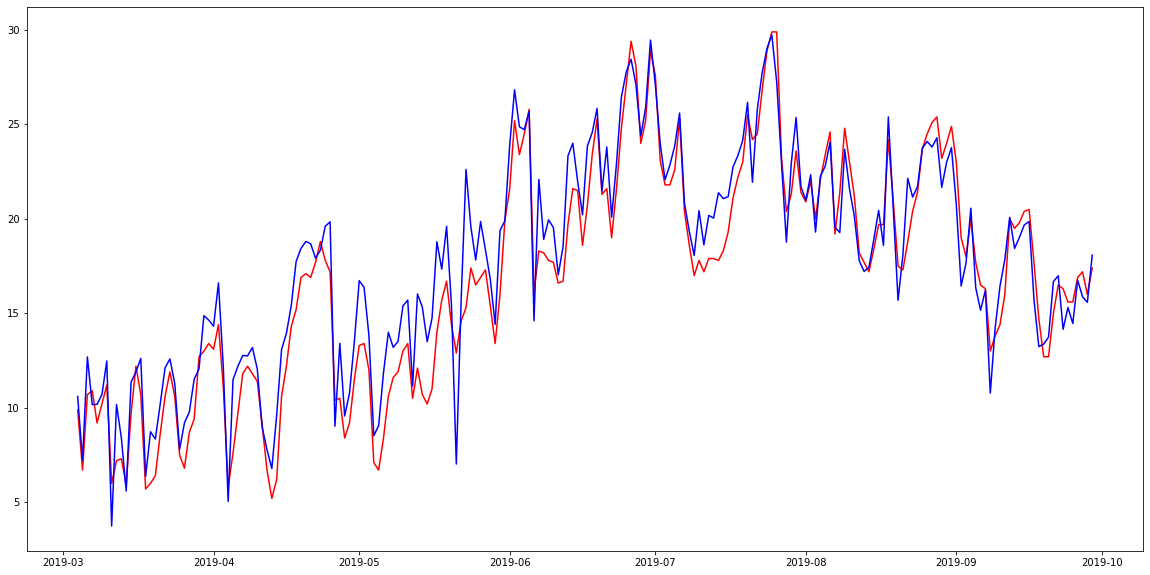

In [63]:
dates2 = np.arange('2019-03-04', '2019-09-30', dtype='datetime64[D]')
plt.plot(dates2, yt, c='red')
plt.plot(dates2, yp, c='blue')
plt.show()

In [64]:
ok_values = 0
bad_values = 0
threshold = 1

diffs = np.diff([yt, yp], axis=0).ravel()
for i in diffs:
    if i <= threshold and i >= -threshold:
        ok_values = ok_values + 1
    else:
        bad_values = bad_values + 1

print('Threshold: +/-', threshold)
print('Amount of good values', ok_values)
print('Amount of bad values', bad_values)
print('Percentage good/bad:', ok_values / (ok_values + bad_values), '/', bad_values / (ok_values + bad_values))

Threshold: +/- 1
Amount of good values 78
Amount of bad values 132
Percentage good/bad: 0.37142857142857144 / 0.6285714285714286


In [65]:
ok_values = 0
bad_values = 0
threshold = 0.5

diffs = np.diff([yt, yp], axis=0).ravel()
for i in diffs:
    if i <= threshold and i >= -threshold:
        ok_values = ok_values + 1
    else:
        bad_values = bad_values + 1

print('Threshold: +/-', threshold)
print('Amount of good values', ok_values)
print('Amount of bad values', bad_values)
print('Percentage good/bad:', ok_values / (ok_values + bad_values), '/', bad_values / (ok_values + bad_values))

Threshold: +/- 0.5
Amount of good values 40
Amount of bad values 170
Percentage good/bad: 0.19047619047619047 / 0.8095238095238095


In [72]:
xtt = xt[0]

diffs = []
random = 0

for i in range(random, len(yt)):
    #xtt = np.array(xtt)
    xtt = np.reshape([xtt], (xtt.shape[0], 1, xtt.shape[1]))
    #print(xtt)
    #xtt = np.array(xtt)
    #print(xtt)
    predictscaled = model.predict(xtt)
    t_dataset_like = np.zeros(shape=(len(predictscaled), 21))
    # put the predicted values in the right field
    t_dataset_like[:,0:7] = predictscaled[:,:]
    # inverse transform and then select the right field
    predict = scaler.inverse_transform(t_dataset_like)[:,0:7]
    # predict = scalery.inverse_transform(predictscaled)
    #print(abs(predict[0] - yi))
    yi = yt[i]
    diffs.append(abs(predict[0][0] - yi))
    
    if i < len(yt) - 1 :
        # xtt = xtt[1:]
        # xtt = np.append(xtt, predictscaled)
        # xtt[2] = predictscaled
        xtt = xtt.ravel()
        xtt = xtt[7:]
        xtt = np.append(xtt, predictscaled)
        xtt = np.array([xtt])

print(diffs)

[1.8356121182441711, 0.1395534664392466, 1.5365385115146637, 3.451918977499007, 6.697756606340409, 9.936978471279144, 5.171596825122833, 21.0884630382061, 11.625285053253172, 17.148485589027402, 18.48600100278854, 15.944356828927994, 16.474772399663927, 18.558662164211274, 20.1112817466259, 27.25533483028412, 17.432674831151964, 11.47879722714424, 6.552990931272506, 42.87157348394394, 4.754178473353385, 11.49629802107811, 8.799897676706314, 9.348929452896117, 9.962376773357391, 12.75179472863674, 13.499696379899978, 12.887571811676025, 12.708229544758796, 13.025071930885314, 9.634684816002846, 3.102112236618995, 4.546351131796836, 5.496722048521041, 7.284254950284958, 7.470100742578506, 7.2420607030391695, 7.5371321618556975, 5.999040132761001, 4.802245309948921, 4.413634568452835, 6.302076697349548, 11.180458760261535, 13.017515051364898, 15.190763145685196, 15.894942677021026, 17.204280775785445, 16.80243121981621, 16.004751032590864, 16.324234229326247, 17.237825021147728, 16.354596

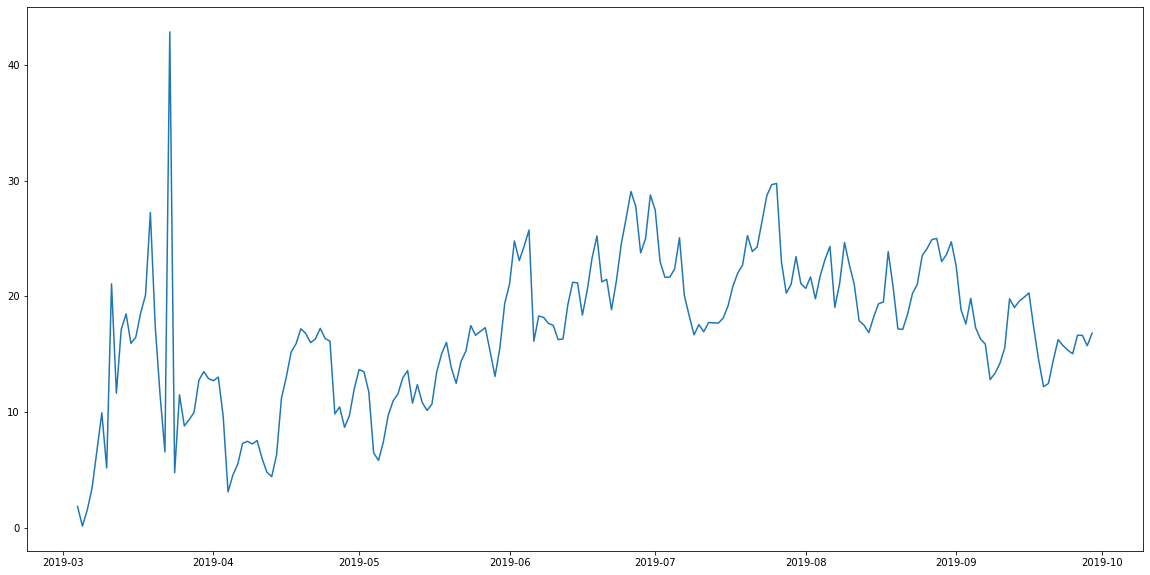

In [73]:
deltas = np.array(diffs)

plt.plot(dates2[random:], deltas)
plt.show()